# Advanced Topics

We introduce some advanced usage in this document. In the following content, all equation numbers refer to [BDM Physics](overview.md#snnu_spectrum) unless specified otherwise. First, import the necessary packages:

In [1]:
# import python packages
import numpy as np
import ipyparallel as ipp

# import plotting package
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# uncomment the following two lines if you have a Hi-DPI monitor and wish to have a better figure resolution
%matplotlib inline
%config InlineBackend.figure_format='retina'

# import snorer
import snorer as sn
print(f'Current version of snorer: {sn.__version__}')

Current version of snorer: 1.0.1


## Distribution across the celestial sphere

We draw how supernova-neutrino-boosted dark matter (SN$\nu$ BDM) distributes across the sky. 

We use [Cassiopeia A](http://snrcat.physics.umanitoba.ca/SNRrecord.php?id=G111.7m02.1) (Cas A) to be our SN in this example. Its $\alpha$ and $\delta$ are 23h23m24s and 58d49m00s respectively and $R_s\approx 3.5$ kpc.
Hence, we obtain the off-center angle $\beta$ and its galactic coordinate by

In [63]:
casA_beta,l_sn,b_sn = sn.equatorial_to_beta('23h23m24s','58d49m00s')
print(f"The off-center angle for Cas A approximates {casA_beta:.3f} rad.")

The off-center angle for Cas A approximates 1.950 rad.


To evaluate the distribution across the sky, it is equivalent to draw

$$
\left.\frac{d\Phi_\chi}{dT_\chi d\Omega} = \tau_s \mathcal{J} j_\chi\right|_{t=\frac{d}{c}+\frac{\ell}{v_\chi}-t_\nu}
$$

on the celestial sphere spanned by the galactic coordinate $\ell$ and $b$.

The corresponding function in **snorer** is [`sn.differential_flux`](../api/main/diff_flux.md) with 10 parameters. The first seven `t`, `Tx`, `mx`, `theta`, `phi`, `Rs`, `beta` are mandatory and the last three `Re = 8.5`, `sigxv0 = 1e-45` and `is_spike = False` are optional. Note that `theta` and `phi` are the zenith and azimuthal angles, cf. [Fig. 1](../manual/overview.md#snv_bdm_scheme) in BDM Physics.

<figure>
<center><img src="../figs/gal_sn.svg" alt="scheme" style="width: 60%;">
<figcaption>Figure 1. Cas A and its location \((\ell_s,b_s)\) on the galactic coordinate. Another point \((\ell_0,b_0)\) is also labeled.
</figure>

Suppose Cas A locates at $(\ell_s,b_s)$ on the galactic coordinate shown in Fig. 1, another point $(\ell_0,b_0)$ that is distant from Cas A by $\theta$ and rotates by $\varphi$ azimuthally. We can determined them through
$$
\theta = \sqrt{\ell^{\prime 2}+b^{\prime 2}},\quad {\rm and} \quad \varphi= \tan^{-1}\left(\frac{\ell^\prime}{b^\prime}\right)
$$
where
$$
\ell^\prime = \ell_0 - \ell_s\quad{\rm and}\quad b^\prime = b_0-b_s.
$$
With $\theta$ and $\varphi$, we further apply both to `sn.differential_flux` to get the differential flux.

Note that we will eventually display the result using the Aitoff projection and in **matplotlib** such projections $\ell\in[-\pi,\pi)$, thus we define a function `wrap_angle` to convert $\ell$ from $[0,2\pi)$ to $[-\pi,\pi)$.
The step-by-step approach is to 
1. Construct a canvas across the entire galactic coordinate
2. Calculate the $(\theta,\varphi)$ for every point $(\ell,b)$ on the canvas
3. Put $(\theta,\varphi)$ into `sn.differential_flux` and retrieve the BDM differential flux at that point

In [59]:
def wrap_angle(l):
    """Confine longitudinal in -pi and pi"""
    return (l + np.pi) % (2 * np.pi) - np.pi

In [67]:
# Setup DM properties
Tx,mx = 5,1
Rs = 3.5 # kpc
t = 350 * sn.constant.year2Seconds

# Setup canvas for galactic coordinate l and b
l_vals = np.linspace(-np.pi,np.pi,800)
b_vals = np.linspace(-np.pi/2,np.pi/2,400)
L,B = np.meshgrid(l_vals,b_vals,indexing="ij")

# Evaluate dtheta and dvarphi for each grid point on the canvas
L_coord = wrap_angle(L - l_sn) # adjust galactic longitude to [-pi, pi) 
B_coord = B - b_sn
dtheta = np.sqrt(L_coord**2 + B_coord**2)
dphi = np.arctan2(L_coord,B_coord)%(2 * np.pi) # using atan2 and mod 2pi to convert galactic latitude to [-pi/2, pi/2)

# Canvas to store the result
diffFlux = np.zeros_like(L)

with np.nditer([dtheta,dphi,diffFlux],op_flags=[['readonly'],['readonly'],['writeonly']]) as it:
    for theta,phi,flux in it:
        flux[...] = sn.differential_flux(t,Tx,mx,theta,phi,Rs,casA_beta)

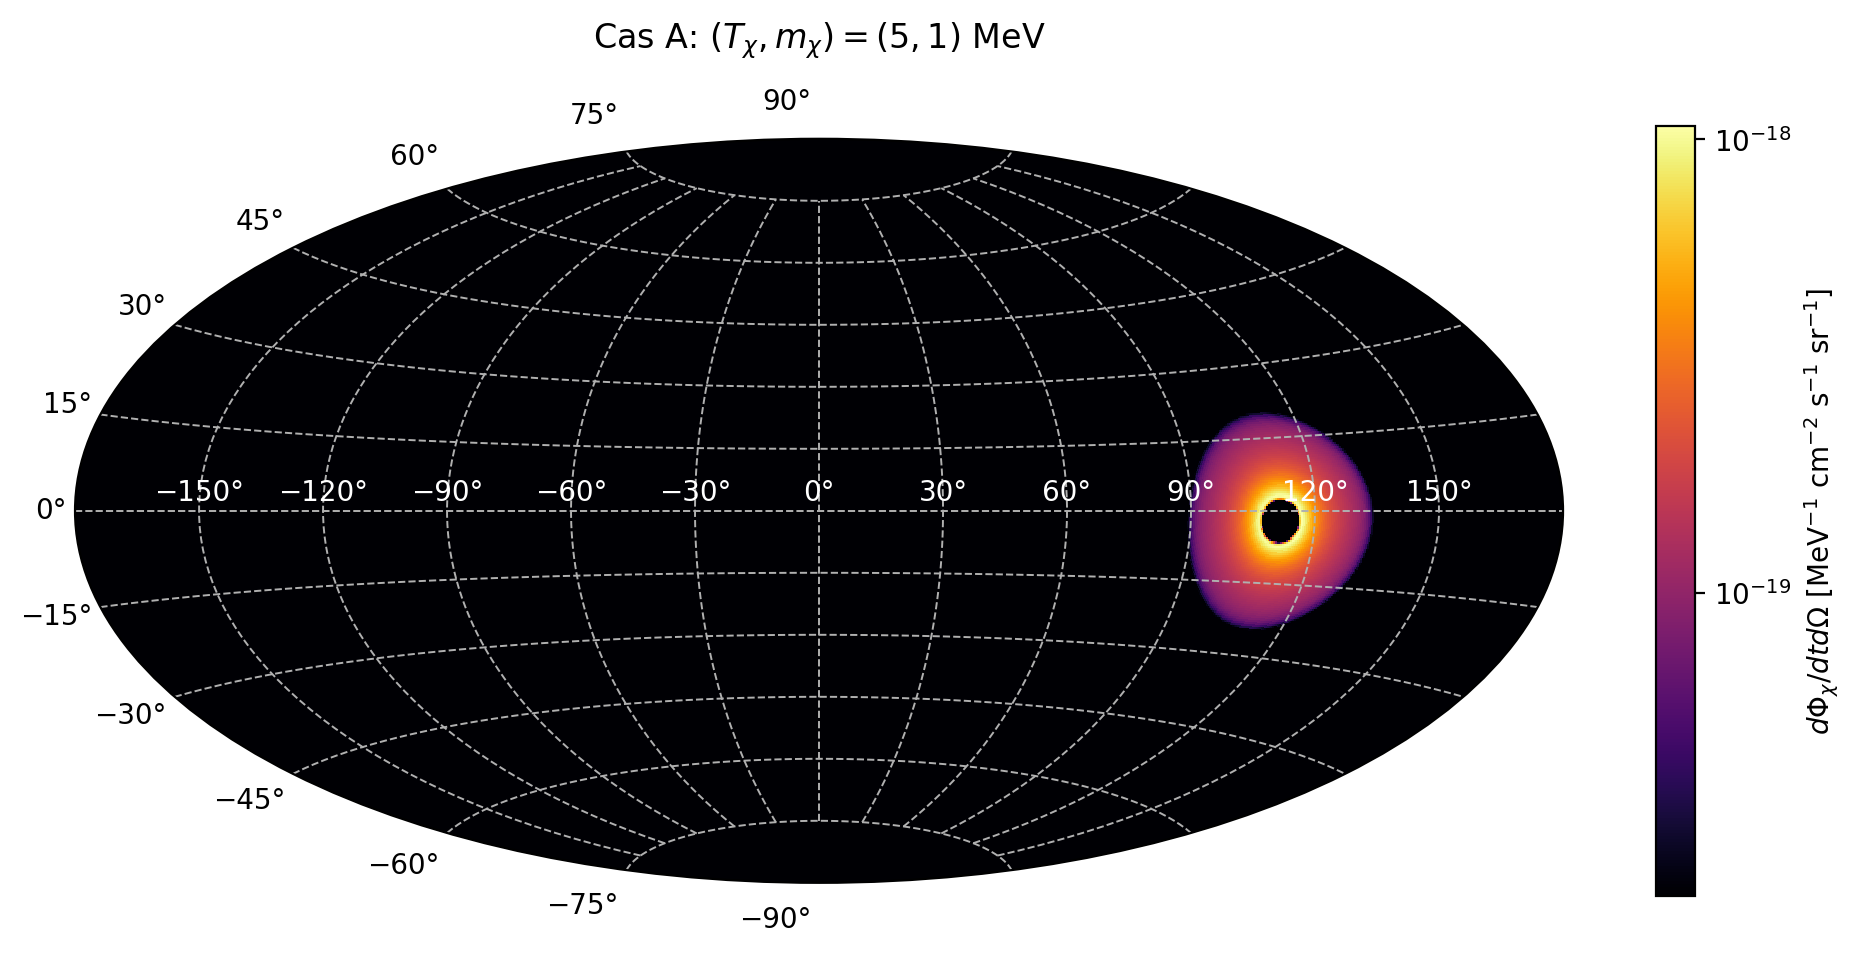

In [69]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111,projection='aitoff')
norm = mcolors.SymLogNorm(linthresh=diffFlux.max()/1e2, vmin=diffFlux.max()/5e1, vmax=diffFlux.max(), base=10)
mesh = ax.pcolormesh(L , B, diffFlux, cmap='inferno', norm=norm, rasterized=True)

cbar = fig.colorbar(mesh, ax=ax, orientation='vertical')
cbar.set_label(r"$d\Phi_\chi/dtd\Omega$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")

# axis label style
ax.tick_params(axis="x", colors="white")
ax.grid(True,linestyle='--', linewidth=0.7)

# axis ticks
x_ticks = np.linspace(-np.pi + np.pi/6, np.pi - np.pi/6, 11)
y_ticks = np.linspace(-np.pi/2, np.pi/2, 13)

ax.set_xticks(x_ticks)  # set galactic longitude tick labels
ax.set_xticklabels([r'−150°', '−120°', '−90°', '−60°', '−30°', '0°', '30°', '60°', '90°', '120°', '150°'])
ax.set_yticks(y_ticks)  # set galactic latitude tick labels
ax.set_yticklabels(['−90°', '−75°', '−60°', '−45°', '−30°', '−15°', '0°', '15°', '30°', '45°', '60°', '75°', '90°'])

ax.set_title(r'Cas A: $(T_\chi,m_\chi)=(5,1)$ MeV',y=1.1)
plt.show()

Note the above is a particular slice of $T_\chi$. For practical case, one should integrate `sn.differential_flux` over a range of $T_\chi$ due to none of the existing detectors having infinite energy resolution.

## User-defined scattering amplitude

Functions `sn.flux` and `sn.event` and the core functions to construct them are all based on energy-independent cross sections $\sigma_{\chi\nu}$ and $\sigma_{\chi e}$.
However, by introducing a specific particle model, cross sections are no longer energy-independent but depend on the Mandelstam variables and model parameters.
Thus, `sn.flux` and `sn.event` are not applicable.

To resolve this issue, we provide a class [`sn.BoostedDarkMatter`](../api/utils/BDM.md) to cope with.
This class integrate all the functions to evaluate BDM flux and event and manipulating halo properties as class *methods*.
Additionally, this class takes scattering amplitudes for $\chi\nu$ and $\chi e$ interactions as its parameters and calculate $d\sigma_{\chi\nu}/d\Omega_{\rm lab}$ and $\sigma_{\chi e}$ automatically. We illustrate this by the famous $L_{\mu-\tau}$ model with DM component.

$$
\begin{alignat*}
    \mathcal{L}_\chi  \supset & -\frac{1}{4}V_{\mu\nu}V^{\mu\nu}+\frac{\varepsilon}{2\cos\theta_W}F_{\mu\nu}V^{\mu\nu}-\frac{1}{2}m_V^2 V_\mu V^\mu  \\
    & \quad -m_\chi \bar{\chi}\chi +g_\chi V_\mu \bar{\chi}\gamma^\mu \chi  \\
    & \quad +g_V V_\mu Q_{\alpha\beta}\left(\bar{\ell}_\alpha\gamma^\mu \ell_\beta +\bar{\nu}_\alpha \gamma^\mu P_L \nu_\beta\right)
\end{alignat*}
$$

with the first line for kinetic mixing, the second line for dark sector interaction and the last for coupling between dark and lepton sector.
The associated Feynman diagrams for $\chi \nu$ and $\chi e$ scatterings are shown in Fig. 2.

<figure>
<center><img src="../figs/feynman_chi-nu.svg" alt="scheme" style="width: 35%;"> 
    <img src="../figs/feynman_chi-e.svg" alt="scheme" style="width: 35%;">
<figcaption>Figure 2. Feynman diagrams for \(\chi\nu\) (left) and \(\chi e\) (right) scatterings described by \(L_{\mu-\tau}\) model.
</figure>

The amplitude squared $|\mathcal{M}|^2$ is given by

$$
|\mathcal{M}|^{2} & =2\left(\frac{\mathcal{Q}}{t-m_{V}^{2}}\right)^{2}[s^{2}+u^{2}
  +4t(m_{1}^{2}+m_{2}^{2}) -2(m_{1}^{2}+m_{2}^{2})^{2}],
$$

where $s$, $t$ and $u$ are Mandelstam variables and $m_1$ and $m_2$ are incoming and being scattered particles respectively. We can encode such information into python function by

In [197]:
def amp2_xv(s,t,u,mx) -> float:
    """DM-v scattering amplitude squared"""
    mV = mx/3
    gV,gx = 1e-06,1e-02
    Q = gV*gx
    return (s**2 + u**2 + 4*t*(mx**2) - 2*(mx**2)**2)*(Q/(t - mV**2))**2

def amp2_xe(s,t,u,mx) -> float:
    """DM-e scattering amplitude squared"""
    mV = mx/3
    me = 0.511 # MeV
    gx,eps = 1e-02,1e-06
    Q = gx*eps
    return 2*(s**2 + u**2 + 4*t*(me**2 + mx**2) - 2*(me**2 + mx**2)**2)*(Q/(t - mV**2))**2

Both functions *only* take ***4 positioning arguments*** with the first three are Mandelstam variables (MeV<sup>2</sup>) and the last is DM mass (MeV). Other model parameters should be defined either in the function or somewhere else. They cannot be the function input(s).

We again use Cas as the example. First build up the instance for Cas A BDM and given it is within our Milky Way, we have $R_g = R_e=8.5$ kpc.

In [111]:
casA_bdm = sn.BoostedDarkMatter(Rs=Rs,Rg=8.5,beta=casA_beta,amp2_xv=amp2_xv,amp2_xe=amp2_xe,is_spike=False)

There are plenty of methods can be called in `casA_bdm`. For instance, we can examine the associated $d\sigma_{\chi\nu}/d\Omega_{\rm lab}$ and $\sigma_{\chi e}$:

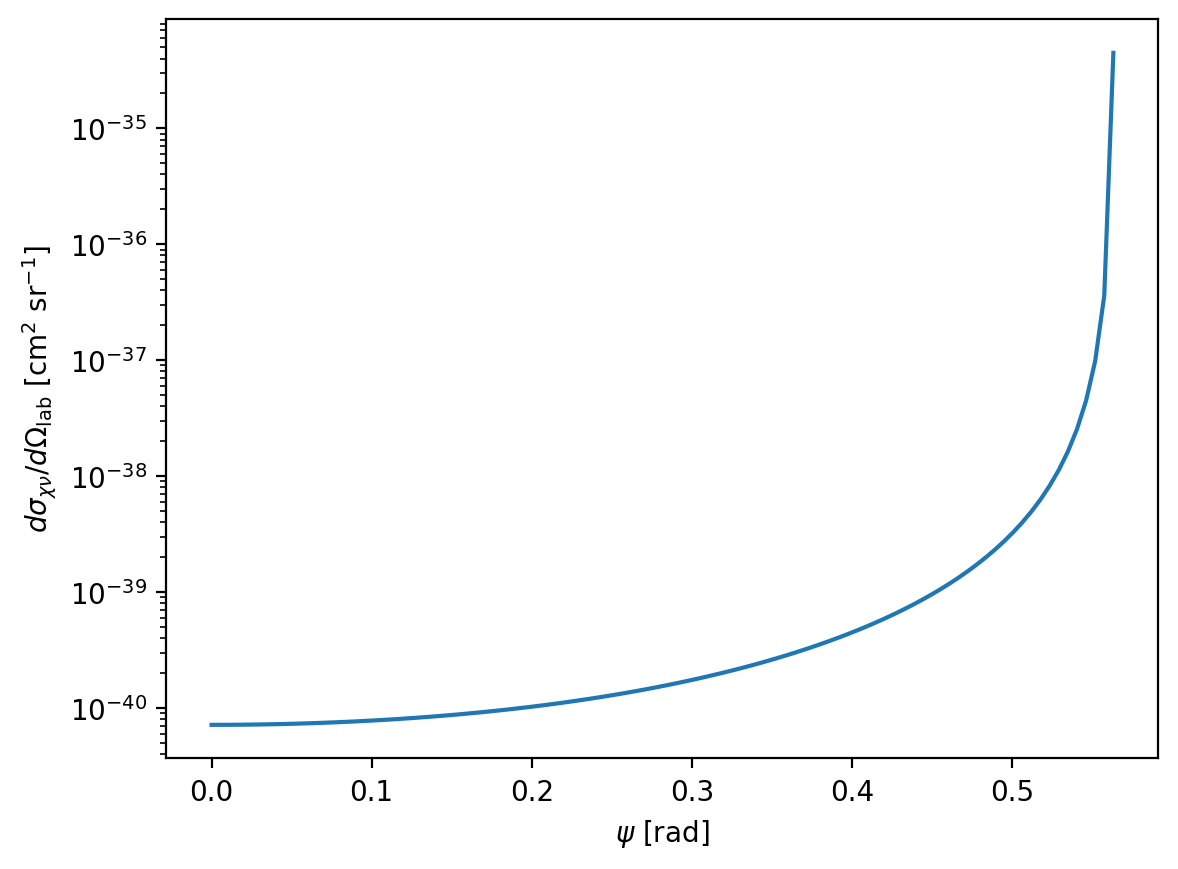

In [137]:
# Differential DM-v cross sections
Tx,mx = 5,1
# Get maximumlly allowed psi
psi_max = sn.get_psiMax(Tx,mx)
psi_max -= psi_max/1000 # avoid diverge at psi_max
psi_vals = np.linspace(0,psi_max,100)
# differential sigma_xv
dsigxv = [casA_bdm.dsigma_xv(Tx,mx,psi) for psi in psi_vals]

# Plot
plt.plot(psi_vals,dsigxv)
plt.yscale('log')
plt.xlabel(r'$\psi$ [rad]')
plt.ylabel(r'$d\sigma_{\chi\nu}/d\Omega_{\rm lab}$ [cm$^2$ sr$^{-1}$]')
plt.show()

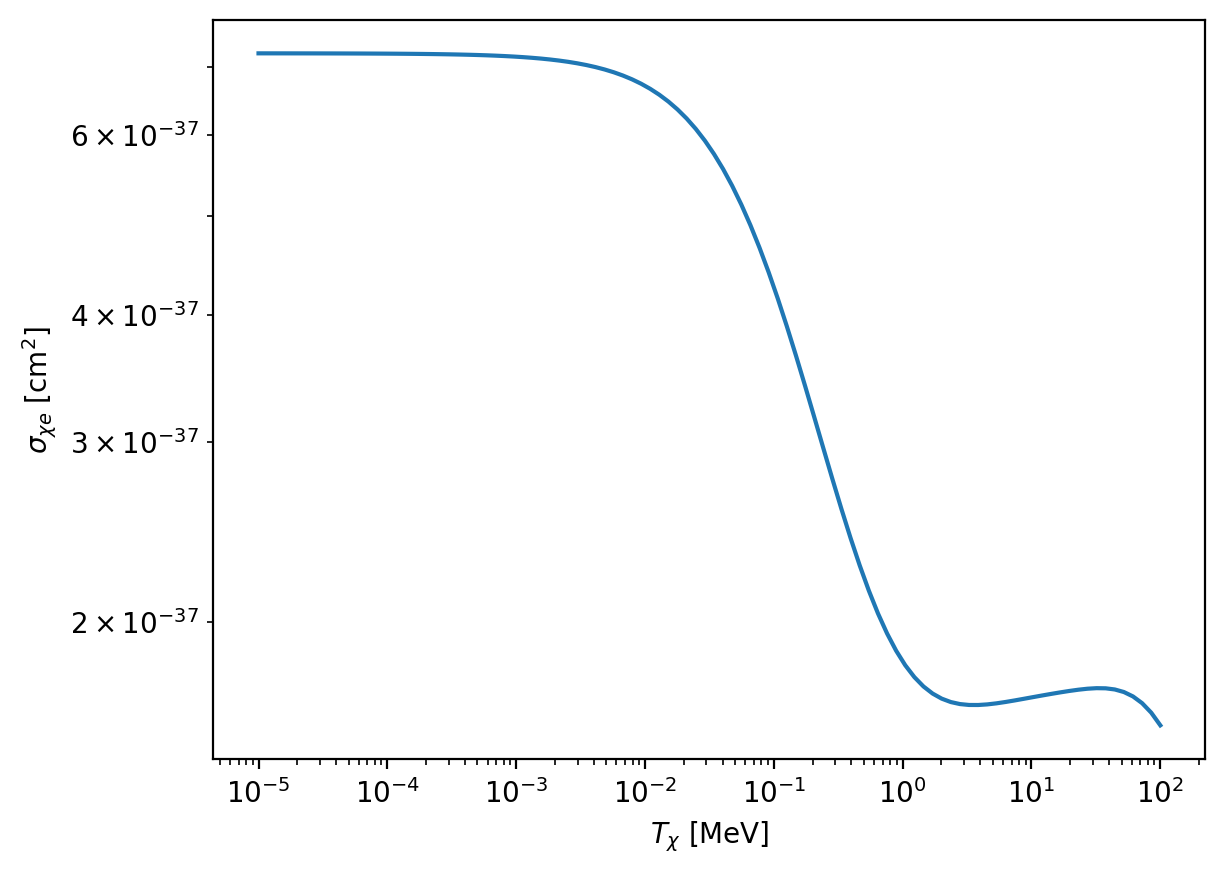

In [135]:
# Differential DM-e cross sections
mx = 1
Tx_vals = np.logspace(-5,2,100)
# differential sigma_xv
sigxe = [casA_bdm.sigma_xe(Tx,mx) for Tx in Tx_vals]

# Plot
plt.plot(Tx_vals,sigxe)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$\sigma_{\chi e}$ [cm$^2$]')
plt.show()

Now we are ready to evaluate the BDM flux and event. Firstly, let's do flux calculation. Given Cas A exploded 350 years ago, it is already 350 year-old. Let's determine the vanishing time first.

In [142]:
# Setup DM properties
Tx,mx = 5,1
Rs = 3.5 # kpc
tvan = sn.get_tvan(Tx,mx,Rs)
print(f'Vanishing time is {tvan/sn.constant.year2Seconds:.2f} years.')

Vanishing time is 557.07 years.


Hence for $(T_\chi,m_\chi)=(5,1)$ MeV, $t_{\rm van}=557.07$ years. However, 350 years have passed, leaving only 207 years atmost before it ceases completely. We can use the `flux` method to evaluate. It takes 3 inputs: `t`, `T_\chi` and `mx`. Additional `**kwargs` determines the cut distances `d_cut` and `r_cut` for SN$\nu$ spectrum and halo profile, respectively, due to both are proportional $1/d^n$ and diverges when $d\to 0$.
Others like `nitn` and `neval` are for **vegas**. Note that this method does not contain any `**kwargs` related to halo profile as the halo behavior is decided  during the initialization of the instance.
See their API pages: [`sn.BoostedDarkMatter`](../api/utils/BDM.md) and [`sn.params`](../api/utils/params.md) for detail.

In [180]:
t0 = 350 * sn.constant.year2Seconds
time_vals = np.linspace(t0,tvan,70)

def get_casA_flux(t,Rs=Rs,Rg=8.5,beta=casA_beta,amp2_xv=amp2_xv,amp2_xe=amp2_xe):
    """flux"""
    import snorer as sn
    Tx,mx = 5,1
    casA_bdm = sn.BoostedDarkMatter(Rs=Rs,Rg=8.5,beta=beta,amp2_xv=amp2_xv,amp2_xe=amp2_xe,is_spike=False)
    return casA_bdm.flux(t,Tx,mx,neval=5000)

# request a cluster
with ipp.Cluster(n = 5) as rc: # 5 cores
    # get a view on the cluster
    view = rc.load_balanced_view()
    # submit the tasks
    asyncresult = view.map_async(get_casA_flux, time_vals)
    # wait interactively for results
    asyncresult.wait_interactive()
    # retrieve actual results
    casA_flux = asyncresult.get()

python(35201) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


python(35213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35214) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35215) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35216) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  0%|          | 0/5 [00:00<?, ?engine/s]

get_casA_flux:   0%|          | 0/70 [00:00<?, ?tasks/s]

Stopping engine(s): 1742019912
engine set stopped 1742019912: {'engines': {'0': {'exit_code': 0, 'pid': 35213, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 35214, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 35215, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 35216, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 35217, 'identifier': '4'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 35201, 'identifier': 'ipcontroller-1742019911-edc4-31540'}


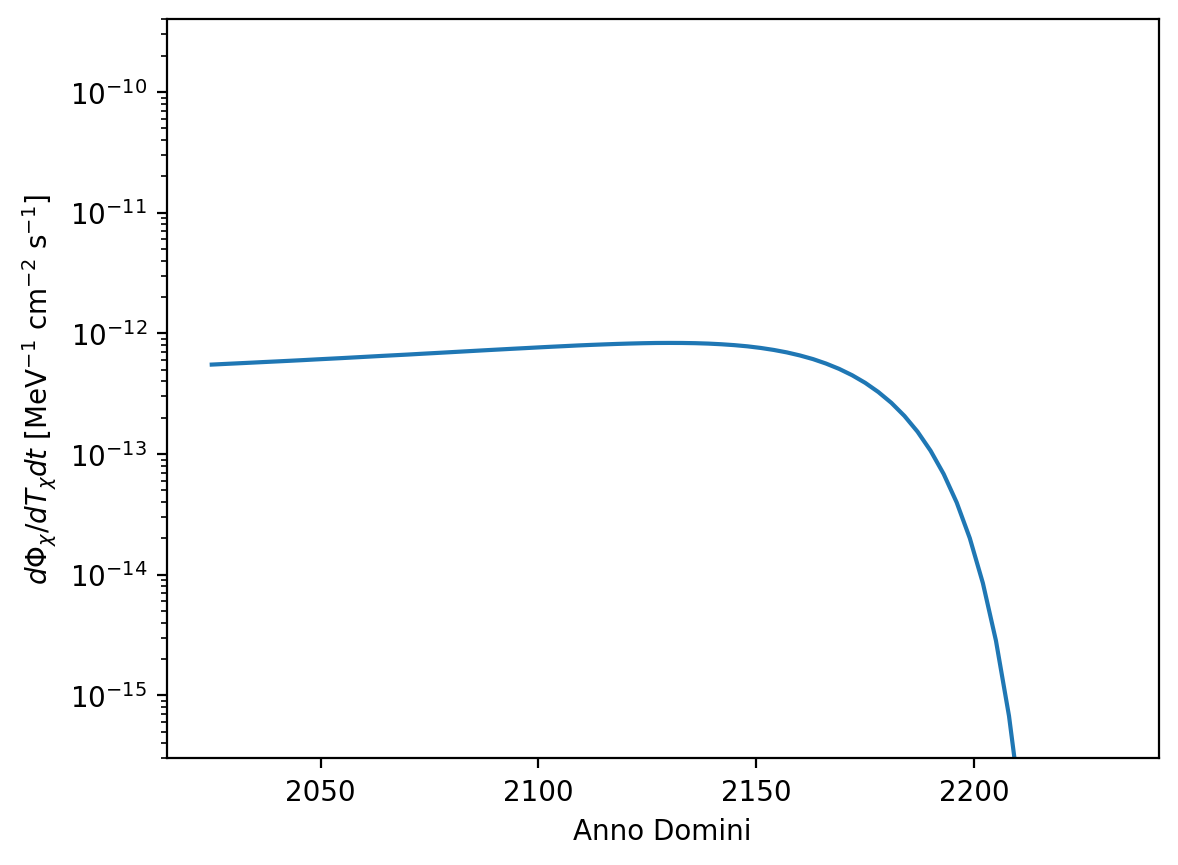

In [188]:
plt.plot(time_vals/sn.constant.year2Seconds + 1675,casA_flux)
plt.yscale('log')
plt.ylim(3e-16,)
plt.xlabel(r'Anno Domini')
plt.ylabel(r'$d\Phi_\chi/dT_\chi dt$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.show()

To evaluate event number, rember the parameter `t_range` in `sn.event` is the integration range of time interval and starts from $t_0=10$ seconds by default.
But it is not the case for Cas A as 350 years has passed. We shoud begin $t_0=350$ years and end with, say, 35 years after $t_0$. Hence,

In [205]:
mx_vals = np.logspace(-6,2,35)

def get_casA_event(mx,Rs=Rs,Rg=8.5,beta=casA_beta,amp2_xv=amp2_xv,amp2_xe=amp2_xe):
    """flux"""
    import snorer as sn
    t0 = 350 * sn.constant.year2Seconds
    tf = (350 + 35) * sn.constant.year2Seconds
    casA_bdm = sn.BoostedDarkMatter(Rs=Rs,Rg=8.5,beta=beta,amp2_xv=amp2_xv,amp2_xe=amp2_xe,is_spike=False)
    try:
        event = casA_bdm.event(mx,t_range=[t0,tf],neval=15000)
    except:
        event = 0
    return event

# request a cluster
with ipp.Cluster(n = 5) as rc: # 5 cores
    # get a view on the cluster
    view = rc.load_balanced_view()
    # submit the tasks
    asyncresult = view.map_async(get_casA_event, mx_vals)
    # wait interactively for results
    asyncresult.wait_interactive()
    # retrieve actual results
    casA_event = asyncresult.get()

python(36580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


python(36594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(36598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  0%|          | 0/5 [00:00<?, ?engine/s]

get_casA_event:   0%|          | 0/35 [00:00<?, ?tasks/s]

engine set stopped 1742023011: {'engines': {'1': {'exit_code': 0, 'pid': 36515, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 36516, 'identifier': '2'}, '0': {'exit_code': 0, 'pid': 36514, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 36517, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 36518, 'identifier': '4'}}, 'exit_code': 0}
Stopping engine(s): 1742023069
engine set stopped 1742023069: {'engines': {'0': {'exit_code': 0, 'pid': 36594, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 36595, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 36596, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 36597, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 36598, 'identifier': '4'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 36580, 'identifier': 'ipcontroller-1742023068-i421-31540'}


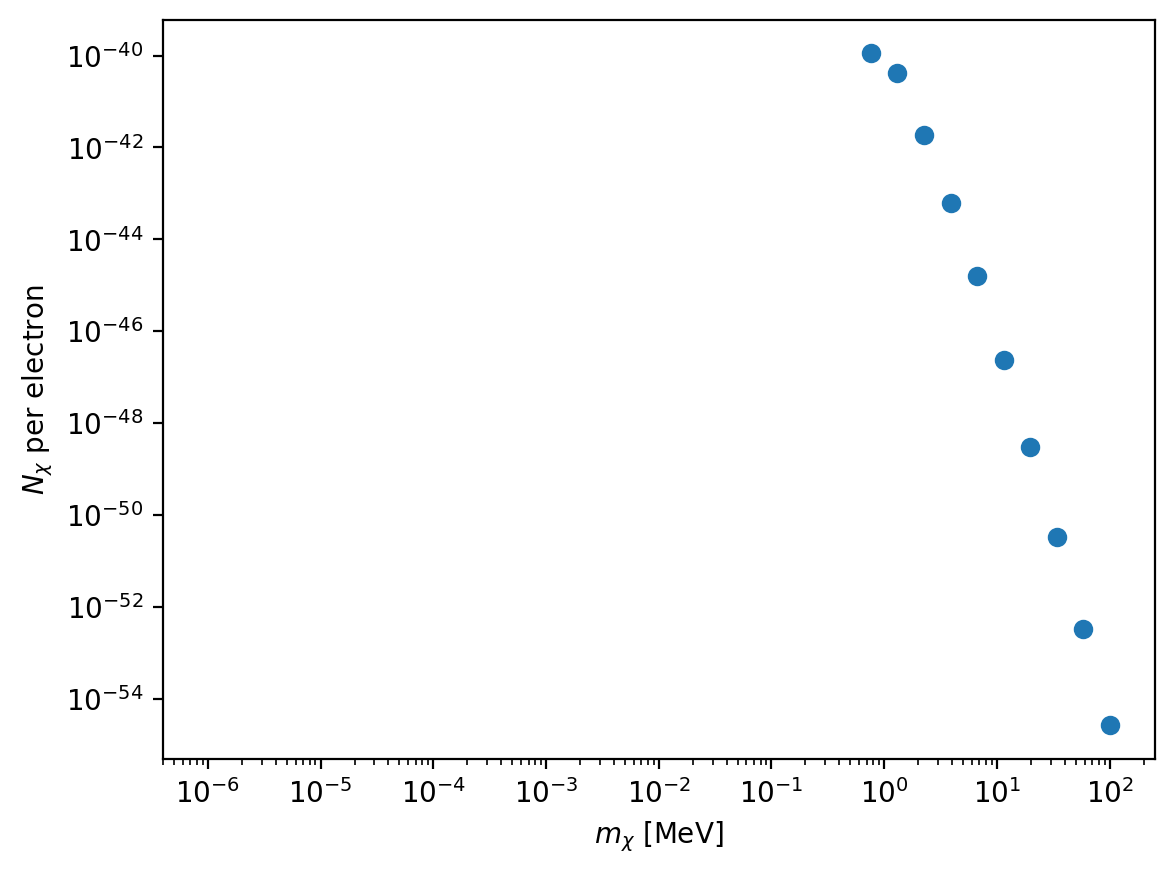

In [211]:
plt.scatter(mx_vals,casA_event)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(3e-16,)
plt.xlabel(r'$m_\chi$ [MeV]')
plt.ylabel(r'$N_\chi$ per electron')
plt.show()

Unlike `sn.event` which the result is normalized to per electron and $\sigma_{\chi e}=1$ cm<sup>2</sup>, in this class instance, $\sigma_{\chi e}$ is determined by user-specified $|\mathcal{M}|^2$, thus the cross section is exact what user expects at such energy.
One only needs to multiply the correct electron number $N_e$ in that detector. For example, Super-K has $7\times 10^{33}$ electrons approximately, then the BDM event is

$$
N_\chi^{\rm SK} = N_e^{\rm SK} \times N_\chi = 7\times 10^{33} N_\chi
$$

In the above plot, one sees that no event when $m_\chi\lesssim 500$ keV. It is because the corresponding $t_{\rm van}$ for $m_\chi$ and $T_\chi$-integrated range are much smaller than 350 years.
Thus BDM from Cas A no longer exists at the present day.

### DM-nucleus scattering

We discuss a more general case when target in the detector is not electron. Though by default `sn.BoostedDarkMatter` assumes $\chi e$ scattering, but the parameter `amp2_xe` is not exclusively for $\chi e$ interaction. 

To elaborate, we assume the target to be interacted is Xenon with target mass approximating $m_t = 1.3\times 10^5$ MeV. We can rewrite `amp2_xe` by

In [303]:
m_xenon = 1.3e5 # xenon mass

def amp2_x_xenon(s,t,u,mx) -> float:
    """DM-xenon scattering amplitude squared"""
    mV = mx/3
    mt = m_xenon # xenon mass, MeV
    gx,eps = 1e-02,1e-06
    Q = gx*eps
    return 2*(s**2 + u**2 + 4*t*(mt**2 + mx**2) - 2*(mt**2 + mx**2)**2)*(Q/(t - mV**2))**2

When initialize `sn.BoostedDarkMatter` instance, we have to specify the target mass `mt` too, such as

In [305]:
casA_bdm_xenon = sn.BoostedDarkMatter(Rs=Rs,Rg=8.5,beta=casA_beta,amp2_xv=amp2_xv,amp2_xe=amp2_x_xenon,mt=m_xenon,is_spike=False)

Now we compare the associated $\sigma_{\chi e}$ and $\sigma_{\chi-{\rm Xe}}$,

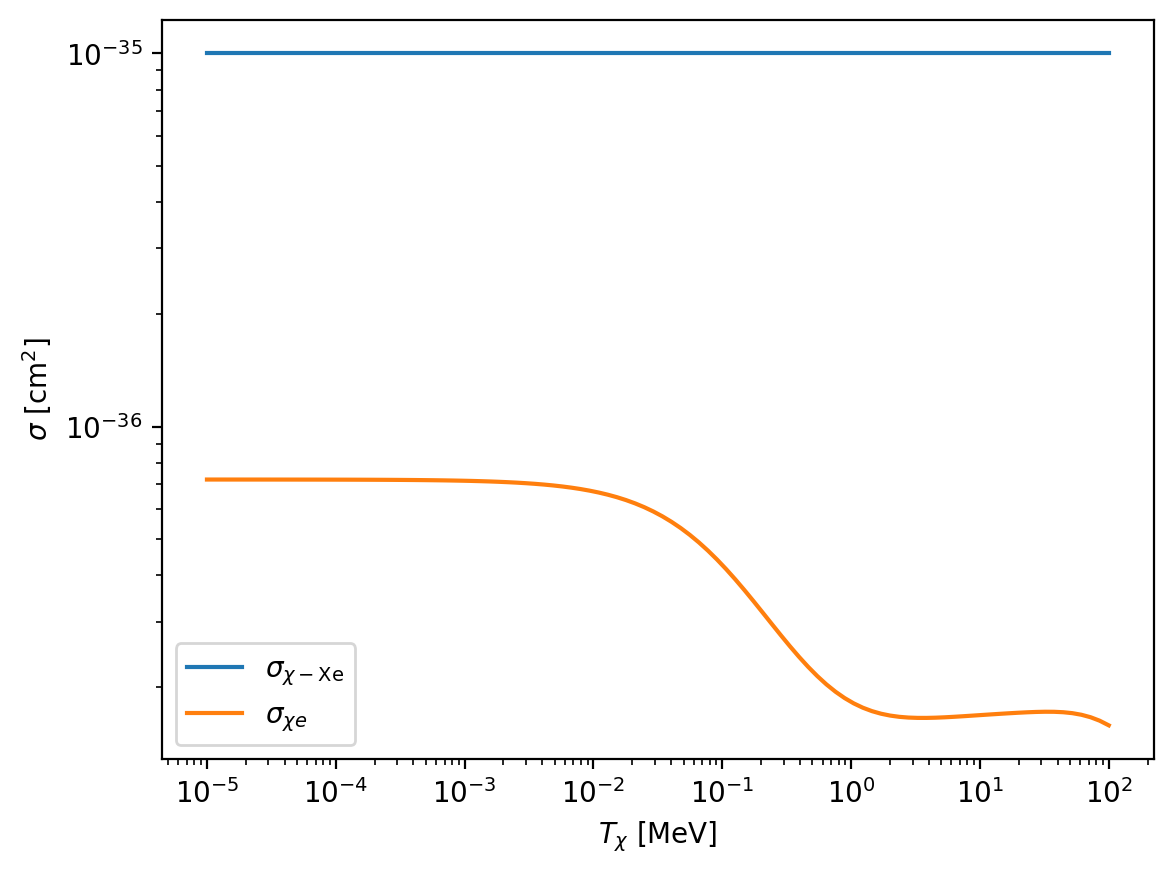

In [311]:
# Differential DM-e cross sections
mx = 1
Tx_vals = np.logspace(-5,2,100)
sigxe = [casA_bdm.sigma_xe(Tx,mx) for Tx in Tx_vals]
sigx_xe = [casA_bdm_xenon.sigma_xe(Tx,mx) for Tx in Tx_vals]

# Plot
plt.plot(Tx_vals,sigx_xe,label=r'$\sigma_{\chi - {\rm Xe}}$')
plt.plot(Tx_vals,sigxe,label=r'$\sigma_{\chi e}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.legend()
plt.show()

Thus in `casA_bdm_xenon`, the method `sigma_xe` is for DM-Xenon interaction cross section. Note that the above is a very naive example and is not plausible in practice. Given when nucleus is under discussion, nucleus form factor should be introduced in `amp2_x_xenon`. We relegate this to the users who work in this field. 

In [309]:
casA_bdm_xenon.sigma_xe = lambda Tx,mx: 1e-35

In [313]:
sn.get_gx?

Signature: sn.get_gx(Ev, mx, psi) -> float
Docstring:
Calculate the probability density for cross section at scattering
angle psi and averaged over azimuthal angle in lab frame. This is
for energy-independent cross section.

Parameters
----------
Ev : array_like
    Incoming neutrino energy, MeV
mx : array_like
    DM mass, MeV
psi : array_like
    Lab frame scattering angle, rad

Returns
-------
out : scalar/ndarray
    Probability density for cross section at psi and averaged
    over azimuthal angle 2*pi. The result is a scalar if the three
    inputs are all scalars. The unit is 1/sr.
File:      ~/Documents/GitHub/snorer/src/snorer/kinematics.py
Type:      function